In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import nltk
import regex as re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib as plt
from sklearn.naive_bayes import BernoulliNB

In [2]:
#Setting my URL name to run
run = 'https://www.reddit.com/r/running.json'

In [3]:
# Setting a header to get rid of my 429 error code
headers = {'User-agent': 'Kevin'}

In [4]:
# Setting my request variable and using the header param to identify me as a unique agent
res = requests.get(run, headers=headers)

In [5]:
# Rechecking status code to make sure it's ok now
res.status_code

200

In [6]:
# Checking res.content to see if it's pulling the information correctly
# res.content

#COMMENTING OUT TO SAVE SPACE

In [7]:
#Setting a json variable to just pull the json dictionary from Reddit's API
the_json = res.json()

In [8]:
#Checking the keys in my dictionary
the_json.keys()

dict_keys(['kind', 'data'])

In [9]:
#Even though there are only two, I'm sorting the keys to get in the habit of doing so
sorted(the_json.keys())

['data', 'kind']

In [10]:
# Checking my kind key to see what values are with it
the_json['kind']

'Listing'

In [11]:
# Since kind didnt have much, assuming most info is in data
# the_json['data']

#COMMENTING OUT TO SAVE SPACE

In [12]:
#Since this is a list of dictionaries, sorting the keys withing the values of data
sorted(the_json['data'].keys())

['after', 'before', 'children', 'dist', 'modhash']

In [13]:
#Since children represents the actual Reddit posts, checking how many I have
len(the_json['data']['children'])

27

In [14]:
#Creating a dataframe quickly to see if it's organizing the data correctly
# pd.DataFrame(the_json['data']['children'])

#COMMENTING OUT TO SAVE SPACE

In [15]:
#Looking at first post and first key  in that post
# the_json['data']['children'][0]['data']

#COMMENTING OUT TO SAVE SPACE

In [16]:
#Checking the name for the last post which needs to be anchor for accessing API
the_json['data']['after']

't3_cbva59'

In [17]:
# checking the name for all 27 posts
# [post['data']['name'] for post in the_json['data']['children']]

#COMMENTING OUT TO SAVE SPACE

In [18]:
param = {'after': 't3_c8bu5g'}

In [19]:
requests.get(run, params=param, headers=headers)

<Response [200]>

In [20]:
runposts = []
after = None
for i in range(38): 
#     print(i) #COMMENTING OUT TO SAVE SPACE
    if after == None:
        params = {}
    else:
        params = {'after': after}
    run = 'https://www.reddit.com/r/running/.json'
    res = requests.get(run, params=params, headers=headers)
    if res.status_code == 200:
        the_json = res.json()
        runposts.extend(the_json['data']['children'])
        after = the_json['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(1) 

In [21]:
# Checking the length of posts to see how many we got
len(runposts)

929

In [22]:
#checking the unique posts to make sure we're not getting overlap
len(set([p['data']['name'] for p in runposts]))

702

In [23]:
#Checking the first element in posts to see if data was pulled correctly
# runposts[0]

#COMMENTING OUT TO SAVE SPACE

In [24]:
cfposts = []
after = None
for i in range(38): 
#     print(i) #COMMENTING OUT TO SAVE SPACE
    if after == None:
        params = {}
    else:
        params = {'after': after}
    cf = 'https://www.reddit.com/r/crossfit.json'
    res = requests.get(cf, params=params, headers=headers)
    if res.status_code == 200:
        the_json = res.json()
        cfposts.extend(the_json['data']['children'])
        after = the_json['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(1)

In [25]:
# Checking the length of posts to see how many we got
len(cfposts)

951

In [26]:
#checking the unique posts to make sure we're not getting overlap
len(set([p['data']['name'] for p in cfposts]))

951

In [27]:
cf_posts = []
for i in cfposts:
    cf_posts.append(i['data']['selftext'])

In [28]:
cf_df = pd.DataFrame(cf_posts)

In [29]:
cf_df['from_cf'] = 1

In [30]:
cf_df.head()

,0,from_cf
0,Did you just have a breakthrough? Post your ne...,1
1,,1
2,,1
3,,1
4,What do you all use? And why do you like it? I...,1


In [31]:
cf_df.rename(columns={0: 'Post'}, inplace=True)

In [32]:
cf_df = cf_df[cf_df['Post'] != '']

In [33]:
cf_df = cf_df.replace('\n',' ', regex=True) 

In [34]:
cf_df.head(10)

,Post,from_cf
0,Did you just have a breakthrough? Post your ne...,1
4,What do you all use? And why do you like it? I...,1
5,"Hello All, &amp;#x200B; First off, I have ne...",1
7,"Hi, I live in a small town with a good crossf...",1
8,Can anyone on here recommend me a good olympic...,1
10,Hi!! I'm new to crossfit -- I finally finished...,1
11,I probably goes without saying that most peopl...,1
12,I am wondering if those of you that can do the...,1
14,"Hey all, First post on The Reddit so be kind l...",1
15,It always seems mega awkward hearing about red...,1


In [35]:
cf_df.shape

(730, 2)

In [36]:
run_posts = []
for i in runposts:
    run_posts.append(i['data']['selftext'])

In [37]:
run_df = pd.DataFrame(run_posts)

In [38]:
run_df.rename(columns={0: 'Post'}, inplace=True)

In [39]:
run_df = run_df[run_df['Post'] != '']

In [40]:
run_df = run_df.replace('\n',' ', regex=True) 

In [41]:
run_df['from_cf'] = 0

In [42]:
run_df.head()

,Post,from_cf
0,***NOTE: This post was graciously stolen (w/ ...,0
1,"With over 600,000 users, there are a lot of p...",0
2,Hello r/running ! I wasn't always a runner. I...,0
4,"I'm a beginner ""runner."" I put in the quotes b...",0
5,"So before I started running, I was severely ou...",0


In [43]:
run_df.head()

,Post,from_cf
0,***NOTE: This post was graciously stolen (w/ ...,0
1,"With over 600,000 users, there are a lot of p...",0
2,Hello r/running ! I wasn't always a runner. I...,0
4,"I'm a beginner ""runner."" I put in the quotes b...",0
5,"So before I started running, I was severely ou...",0


In [44]:
run_df.shape

(869, 2)

In [45]:
df = pd.concat([run_df, cf_df], axis=0)

In [46]:
df.head(10)

,Post,from_cf
0,***NOTE: This post was graciously stolen (w/ ...,0
1,"With over 600,000 users, there are a lot of p...",0
2,Hello r/running ! I wasn't always a runner. I...,0
4,"I'm a beginner ""runner."" I put in the quotes b...",0
5,"So before I started running, I was severely ou...",0
6,"###**Last week, on Photo Friday:** /u/aranaSF...",0
8,Hello fellow runners! I looked to join a runni...,0
9,"I'm F43, only 5lb away from being ""overweight""...",0
10,I'm using the Hal Higdon Novice 2 half-maratho...,0
11,"Hey runners, it's another day and it is time t...",0


In [47]:
df.shape

(1599, 2)

In [48]:
df.describe()

,from_cf
count,1599.000000
mean,0.456535
std,0.498263
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [49]:
df.dtypes

Post       object
from_cf     int64
dtype: object

In [50]:
# Defining my X and my y

X = df['Post']
y = df['from_cf']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [52]:
def post_to_words(raw_post):
    # Function to convert a raw post to a string of words
    # The input is a single string (post), and 
    # the output is a single string (a preprocessed post)
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [53]:
# Get the number of posts based on the dataframe size.
total_posts = X_train.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the clean posts.
clean_train_posts = []
clean_test_posts = []

There are 1199 posts.


In [54]:
clean_train_posts

[]

In [55]:
print("Cleaning and parsing the training set posts...")

j = 0
for train_post in X_train:
    # Convert post to words, then append to clean_train_post.
    clean_train_posts.append(post_to_words(train_post))
    
    j += 1

# Doing the same for the testing set.

print("Cleaning and parsing the testing set posts...")

for test_post in X_test:
    # Convert post to words, then append to clean_test_posts.
    clean_test_posts.append(post_to_words(test_post))
        
    j += 1

Cleaning and parsing the training set posts...


/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://www.instagram.com/p/ByBe5uIHS8A/?igshid=134on10te20yc" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Cleaning and parsing the testing set posts...


In [56]:
clean_test_posts

['rogue sold fraser metcon minutes love shoes though would great get get new nanos time comparison oh well',
 'first apologize missed posts prior reviews tried searching threads first admit best title says curious anyone experience therunexperience training program enjoy youtube videos advice never used coach let alone online coach training reference currently run miles per week mid distance training runs finished trail race get sore anymore would like work whatever need work lol live close running clubs coaches looking online something reasonably priced thanks sorry rambling',
 'sweat lot average female summer months come home run basically wring shirt sweat found lot easier comfortable wear sports bra shorts running sure like okay really shy nervous attention might get time feminist want uncomfortable somebody thinks keep mid drift covered women femmes run sports bra okay',
 'pretty straight forward recs box st croix working month see crossfit website inactive anyone know box still o

In [57]:
clean_train_posts

['map https imgur com mgpcxd love strava heatmap feature even finally decided go summit would always month trials check map sydney map looks like years km started running years ago training city surf first moved sydney popular km race city bondi beach love running time clocked fair amount distance mostly running around really enjoy exploring new parts city otherwise pass also clearly favourite stomping grounds commuting routes moved couple times familiar sydney running scene might recognise classics like sydney marathon bay run city surf marathon also ran course bridge walk couple times actual day since discouraged great fun x posting r sydney https mail google com r sydney extra running details',
 'looking slow runners actually wonder might interest slow running sub running couple years getting better yes know long runs build endurance etc often stop running couple months due bunions help course cycle swim hike keep fit ways give idea last night ran km nearly minutes started running m

In [58]:
# Instantiate the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             max_features=5_000)

In [59]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(clean_train_posts)

test_data_features = vectorizer.transform(clean_test_posts)

# Numpy arrays are easy to work with, so convert the result to an 
# array.
train_data_features = train_data_features.toarray()

In [60]:
print(train_data_features.shape)

(1199, 5000)


In [61]:
print(test_data_features.shape)

(400, 5000)


In [62]:
y_train.shape

(1199,)

In [63]:
train_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [64]:
train_data_features[0:6]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [65]:
vocab = vectorizer.get_feature_names()
print(vocab)

['aab', 'ab', 'abandoned', 'abdominal', 'abilities', 'ability', 'able', 'abroad', 'abs', 'absolute', 'absolutely', 'ac', 'accept', 'accepted', 'access', 'accessory', 'accident', 'accidentally', 'acclimated', 'accommodate', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'according', 'account', 'accurate', 'accustomed', 'ache', 'achievable', 'achieve', 'achievement', 'achievements', 'achieving', 'achill', 'achilles', 'aching', 'acid', 'acting', 'action', 'active', 'actively', 'activities', 'activity', 'actual', 'actually', 'adapt', 'add', 'added', 'adding', 'addition', 'additional', 'adductor', 'adequate', 'adidas', 'adjust', 'adjusted', 'adjustment', 'adjustments', 'admit', 'admittedly', 'adrenaline', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'advised', 'aerial', 'aerobic', 'aesthetics', 'af', 'affair', 'affect', 'affiliate', 'affiliated', 'affiliates', 'afford', 'affordable', 'afraid', 'afternoon', 'aftershokz', 'afterward', 'age', 'ages', 'aggravat

In [66]:
vocab[0:5]

['aab', 'ab', 'abandoned', 'abdominal', 'abilities']

In [67]:
#Checking baseline to see if our model is out performing the null model
df['from_cf'].value_counts(normalize=True)

0    0.543465
1    0.456535
Name: from_cf, dtype: float64

In [68]:
lr = LogisticRegression()

In [69]:
lr.fit(train_data_features, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [70]:
print(f'Logistic Regression Intercept: {lr.intercept_}')
print(f'Logistic Regression Coefficient: {lr.coef_}')

Logistic Regression Intercept: [1.20439803]
Logistic Regression Coefficient: [[ 7.82496990e-06  3.77911928e-02  2.80468817e-02 ... -1.92330632e-06
   4.37506175e-07  1.43779039e-04]]


In [71]:
print(f'Logistic Regression Coefficient: {np.exp(lr.coef_)}')

Logistic Regression Coefficient: [[1.00000783 1.03851436 1.0284439  ... 0.99999808 1.00000044 1.00014379]]


In [72]:
#Generate predicted values.
print(f'Logreg predicted values: {lr.predict(train_data_features[0:5])}')

Logreg predicted values: [0 0 0 1 0]


In [73]:
#Generate predicted probabilities.
print(f'Logreg predicted probabilities: {lr.predict_proba(train_data_features[0:5])}')

Logreg predicted probabilities: [[9.99999960e-01 4.00301226e-08]
 [1.00000000e+00 1.54841977e-12]
 [9.99999996e-01 4.41484787e-09]
 [2.37296261e-02 9.76270374e-01]
 [9.99999500e-01 5.00097118e-07]]


In [74]:
# Evaluate model on training data.
print(f' Train Score is: {np.round(lr.score(train_data_features, y_train), decimals=4)*100}')

 Train Score is: 99.92


In [75]:
# Evaluate model on testing data.

print(f' Test Score is: {np.round(lr.score(test_data_features, y_test), decimals=4)*100}')

 Test Score is: 96.5


In [76]:
train_data_features_cv = pd.DataFrame(train_data_features,
                                columns = vectorizer.get_feature_names())

In [77]:
X_df = pd.DataFrame(train_data_features.sum(), index = vectorizer.get_feature_names(), columns =['count'])

In [78]:
X_df['coef'] = lr.coef_.T

In [79]:
X_df.isnull().sum()

count    0
coef     0
dtype: int64

In [80]:
top_10 = X_df.sort_values(by=['coef'], ascending=False).head(10)

In [81]:
top_10

,count,coef
crossfit,91199,1.684384
gym,91199,1.110697
box,91199,1.097957
workout,91199,0.873621
wod,91199,0.868367
fit,91199,0.717857
games,91199,0.673748
boxes,91199,0.643575
row,91199,0.625302
assault,91199,0.621556


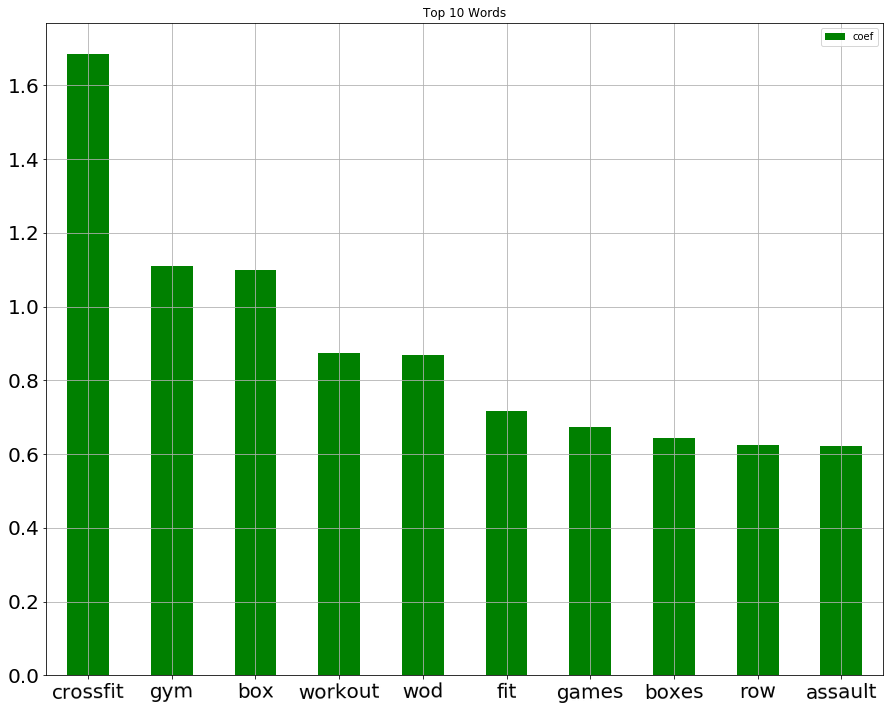

In [83]:
top_10['coef'].plot.bar(
                        rot = 1, 
                        figsize=(15,12),
                        color = 'green',
                        grid=True,
                        legend=True,
                        fontsize=20,
                        title="Top 10 Words");

In [84]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [85]:
# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 

# Fit your model
pipe.fit(X_train, y_train)

# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')

# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Cross_val_score is: 0.9324183276145476
 Training Score is: 0.9991659716430359
 Test Score is: 0.9475


In [86]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 10_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9299416180150125


{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [87]:
gs.score(X_train, y_train)

0.9991659716430359

In [88]:
gs.score(X_test, y_test)

0.945

In [89]:
Counter(vocab).keys() # equals to list(set(words))

dict_keys(['aab', 'ab', 'abandoned', 'abdominal', 'abilities', 'ability', 'able', 'abroad', 'abs', 'absolute', 'absolutely', 'ac', 'accept', 'accepted', 'access', 'accessory', 'accident', 'accidentally', 'acclimated', 'accommodate', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'according', 'account', 'accurate', 'accustomed', 'ache', 'achievable', 'achieve', 'achievement', 'achievements', 'achieving', 'achill', 'achilles', 'aching', 'acid', 'acting', 'action', 'active', 'actively', 'activities', 'activity', 'actual', 'actually', 'adapt', 'add', 'added', 'adding', 'addition', 'additional', 'adductor', 'adequate', 'adidas', 'adjust', 'adjusted', 'adjustment', 'adjustments', 'admit', 'admittedly', 'adrenaline', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'advised', 'aerial', 'aerobic', 'aesthetics', 'af', 'affair', 'affect', 'affiliate', 'affiliated', 'affiliates', 'afford', 'affordable', 'afraid', 'afternoon', 'aftershokz', 'afterward', 'age', 'ages',

In [90]:
len(Counter(vocab).values()) # counts the elements' frequency

5000

In [91]:
bnb = BernoulliNB()

In [92]:
BernoulliNB.fit(train_data_features, y_train)

TypeError: fit() missing 1 required positional argument: 'y'

In [94]:
#Create a Gaussian Classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()


In [95]:
gnb.fit(train_data_features, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [99]:
# Evaluate model on training data.
print(f' Gaussian NB train Score is: {np.round(gnb.score(train_data_features, y_train), decimals=4)*100}')

 Gaussian NB train Score is: 96.5


In [105]:
# Evaluate model on test data.
print(f' Gaussian NB Test Score is: {np.round(gnb.score(test_data_features_gnb, y_test), decimals=4)*100}')

 Gaussian NB Test Score is: 85.0


In [104]:
test_data_features_gnb = test_data_features.toarray()